In [1]:
# Hybrid CNN+ViT Pathologist Tool with GradCAM + Report

!pip install -q timm

import os, math, random, time
import numpy as np
import pandas as pd
import cv2
from PIL import Image
from datetime import datetime
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.models import resnet18, ResNet18_Weights
import timm
from sklearn.metrics import confusion_matrix, roc_curve, auc

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 6.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 3.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.7 MB/s eta 0:00:00:00:0100:01


In [6]:
DATASET_PATH = "/kaggle/input/histopathologic-cancer-detection"
TRAIN_DIR = os.path.join(DATASET_PATH, "train")
LABELS_CSV = os.path.join(DATASET_PATH, "train_labels.csv")

USE_SUBSET = True
N_IMAGES_FOR_SUBSET = 20000

BATCH_SIZE = 64
EPOCHS = 3
LR = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

OUTPUT_DIR = "/kaggle/working/patho_outputs"
HEATMAP_DIR = os.path.join(OUTPUT_DIR, "heatmaps")
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(HEATMAP_DIR, exist_ok=True)
REPORT_CSV = os.path.join(OUTPUT_DIR, "inference_report.csv")
MODEL_OUT = os.path.join(OUTPUT_DIR, "hybrid_cnn_vit.pth")

print("Device:", DEVICE)
print("Outputs ->", OUTPUT_DIR)

Device: cuda
Outputs -> /kaggle/working/patho_outputs


In [8]:
# Dataset
class HistopathDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_id = str(row["id"])
        if not img_id.lower().endswith(".tif"):
            img_id = img_id + ".tif"
        img_path = os.path.join(self.img_dir, img_id)
        label = int(row["label"])
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img_t = self.transform(img)
        else:
            img_t = transforms.ToTensor()(img)
        return img_t, label, img_id

In [9]:
# Transforms

IMG_SIZE = 224
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

In [10]:
# Load CSV and sample subset

df = pd.read_csv(LABELS_CSV)
df["id"] = df["id"].astype(str) + ".tif"
print("Total images in CSV:", len(df))

if USE_SUBSET:
    take = min(N_IMAGES_FOR_SUBSET, len(df))
    df = df.sample(take, random_state=42).reset_index(drop=True)
    print("Using subset:", len(df))

Total images in CSV: 220025
Using subset: 20000


In [11]:
# Train/val split
train_frac = 0.8
train_n = int(train_frac * len(df))
train_df = df.iloc[:train_n].reset_index(drop=True)
val_df   = df.iloc[train_n:].reset_index(drop=True)
print("Train:", len(train_df), "Val:", len(val_df))

train_ds = HistopathDataset(train_df, TRAIN_DIR, transform=transform)
val_ds   = HistopathDataset(val_df, TRAIN_DIR, transform=transform)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

Train: 16000 Val: 4000


In [12]:
# Model: Hybrid CNN + ViT
class HybridCNNViT(nn.Module):
    def __init__(self, pretrained_cnn=True, pretrained_vit=True):
        super().__init__()
        # ✅ updated weights API
        if pretrained_cnn:
            self.cnn = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        else:
            self.cnn = resnet18(weights=None)
        self.cnn.fc = nn.Identity()
        self.cnn_dim = 512

        self.vit = timm.create_model("vit_base_patch16_224", pretrained=pretrained_vit)
        vit_dim = self.vit.head.in_features
        self.vit.head = nn.Identity()

        self.fc = nn.Sequential(
            nn.Linear(self.cnn_dim + vit_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 2)
        )

    def forward(self, x):
        cnn_feat = self.cnn(x)    # (B,512)
        vit_feat = self.vit(x)    # (B,vit_dim)
        fused = torch.cat([cnn_feat, vit_feat], dim=1)
        out = self.fc(fused)
        return out

model = HybridCNNViT(pretrained_cnn=True, pretrained_vit=True).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 185MB/s]


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [13]:
# Training loop
print("Starting training...")

train_losses = []
train_accuracies = []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    total = 0
    correct = 0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")

    for imgs, labels, ids in pbar:
        imgs = imgs.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        batch_size = labels.size(0)
        running_loss += loss.item() * batch_size
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += batch_size
        pbar.set_postfix({"loss": f"{running_loss/total:.4f}", "acc": f"{correct/total:.4f}", "images": total})

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

print("Finished training.")

Starting training...


Epoch 3/3: 100%|██████████| 250/250 [05:11<00:00,  1.25s/it, loss=0.0563, acc=0.9798, images=16000]

Finished training.


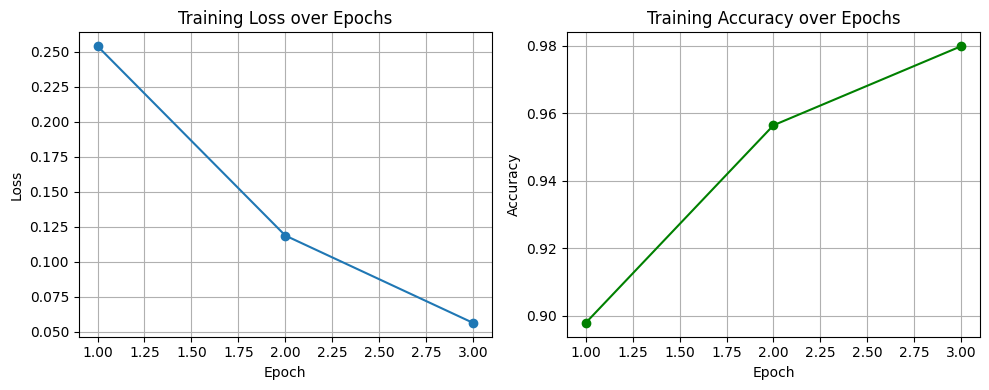

Saved model to: /kaggle/working/patho_outputs/hybrid_cnn_vit.pth


In [14]:
# Plot training loss and accuracy
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(range(1, EPOCHS+1), train_losses, marker='o')
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(range(1, EPOCHS+1), train_accuracies, marker='o', color='green')
plt.title("Training Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)

plt.tight_layout()
plt.show()

torch.save(model.state_dict(), MODEL_OUT)
print("Saved model to:", MODEL_OUT)

In [16]:
# Grad-CAM implementation

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None
        self.fh = target_layer.register_forward_hook(self._save_activation)
        self.bh = target_layer.register_full_backward_hook(self._save_gradient)

    def _save_activation(self, module, inp, out):
        self.activations = out

    def _save_gradient(self, module, grad_in, grad_out):
        self.gradients = grad_out[0]

    def remove_hooks(self):
        self.fh.remove()
        self.bh.remove()

    def generate_cam(self, input_tensor, class_idx=None):
        outputs = self.model(input_tensor)
        if class_idx is None:
            class_idx = outputs.argmax(dim=1).item()
        score = outputs[0, class_idx]
        self.model.zero_grad()
        score.backward(retain_graph=True)

        grads = self.gradients[0]
        acts  = self.activations[0]
        weights = grads.mean(dim=(1,2))
        cam = (weights[:, None, None] * acts).sum(dim=0)
        cam = torch.relu(cam)
        if cam.numel() == 0:
            return np.zeros((input_tensor.size(2), input_tensor.size(3)), dtype=np.float32)
        cam = cam - cam.min()
        if cam.max() != 0:
            cam = cam / cam.max()
        cam_np = cam.detach().cpu().numpy()
        H_in, W_in = input_tensor.shape[2], input_tensor.shape[3]
        cam_resized = cv2.resize(cam_np, (W_in, H_in))
        cam_resized = (cam_resized - cam_resized.min()) / (cam_resized.max() - cam_resized.min() + 1e-8)
        return cam_resized

# attach GradCAM to last ResNet block
gradcam = GradCAM(model, model.cnn.layer4)

In [ ]:
# Inference + CAM + Report

def compute_uncertainty(probs):
    ent = -np.sum(probs * np.log(np.clip(probs, 1e-12, 1.0)))
    max_ent = math.log(len(probs))
    return ent / (max_ent + 1e-12)

report_rows = []
ts = datetime.utcnow().strftime("%Y%m%dT%H%M%SZ")

model.eval()
with torch.no_grad():
    for imgs, labels, img_ids in tqdm(val_loader, desc="Running inference (probabilities)"):
        imgs = imgs.to(DEVICE)
        outputs = model(imgs)
        probs_batch = torch.softmax(outputs, dim=1).cpu().numpy()

        for i in range(imgs.size(0)):
            pid = img_ids[i]
            p   = probs_batch[i]
            pred_label = int(np.argmax(p))
            confidence = float(np.max(p))
            uncertainty = float(compute_uncertainty(p))

            inp = imgs[i:i+1].clone().detach().to(DEVICE).requires_grad_(True)
            with torch.enable_grad():
                cam = gradcam.generate_cam(inp, class_idx=pred_label)

            orig_path = os.path.join(TRAIN_DIR, pid)
            orig_img = np.array(Image.open(orig_path).convert("RGB"))
            orig_h, orig_w = orig_img.shape[:2]
            cam_orig = cv2.resize(cam, (orig_w, orig_h))

            thresh = 0.5
            tumor_mask = cam_orig >= thresh
            tumor_area_pct = float(tumor_mask.sum() / (orig_h * orig_w) * 100.0)

            if tumor_mask.sum() == 0:
                aggr_str, aggr_mean = "N/A", 0.0
            else:
                aggr_mean = float(cam_orig[tumor_mask].mean())
                if aggr_mean >= 0.6:
                    aggr_str = "High"
                elif aggr_mean >= 0.3:
                    aggr_str = "Medium"
                else:
                    aggr_str = "Low"

            heatmap_uint8 = (cam_orig * 255).astype(np.uint8)
            heatmap_color = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)
            heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)
            overlay = ((0.6 * orig_img.astype(np.float32)) + (0.4 * heatmap_color.astype(np.float32))).astype(np.uint8)

            heatmap_fname = f"{pid.replace('.tif','')}_heatmap_{ts}.png"
            heatmap_path = os.path.join(HEATMAP_DIR, heatmap_fname)
            Image.fromarray(overlay).save(heatmap_path)

            review_flag = False
            if confidence < 0.75 or uncertainty > 0.5:
                review_flag = True
            if pred_label == 1 and tumor_area_pct < 1.0:
                review_flag = True

            report_rows.append({
                "image_id": pid,
                "pred_label": "Tumor" if pred_label == 1 else "Normal",
                "prob_normal": float(p[0]),
                "prob_tumor": float(p[1]),
                "confidence": confidence,
                "uncertainty": uncertainty,
                "tumor_area_pct": tumor_area_pct,
                "aggressiveness": aggr_str,
                "aggressiveness_mean_intensity": aggr_mean,
                "review_flag": bool(review_flag),
                "heatmap_file": heatmap_fname,
                "timestamp_utc": datetime.utcnow().isoformat()
            })

# Save report
df_report = pd.DataFrame(report_rows)
df_report.to_csv(REPORT_CSV, index=False)
print("Saved report CSV to:", REPORT_CSV)
print("Saved heatmaps to:", HEATMAP_DIR)

Running inference (probabilities): 100%|██████████| 63/63 [03:29<00:00,  3.32s/it]

Saved report CSV to: /kaggle/working/patho_outputs/inference_report.csv
Saved heatmaps to: /kaggle/working/patho_outputs/heatmaps


Confusion matrix on validation subset:
 [[2174  198]
 [ 104 1524]]


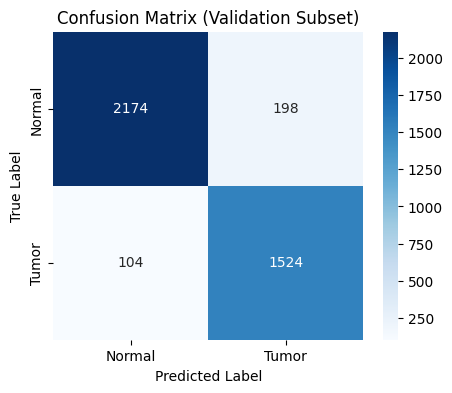

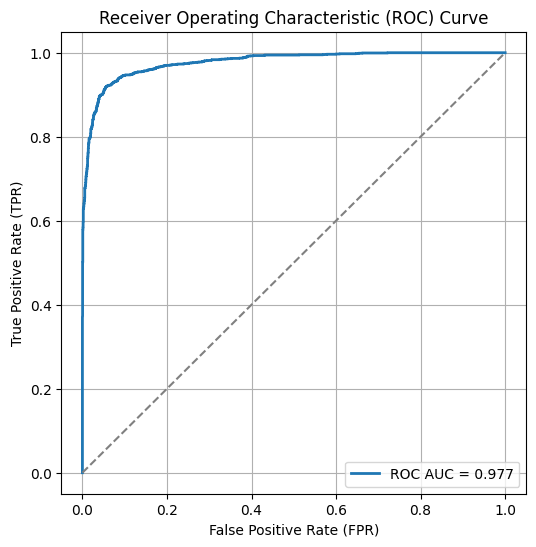

In [25]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score


# Metrics
y_true, y_pred, y_prob = [], [], []
id_to_true = dict(zip(val_df["id"].astype(str), val_df["label"].astype(int)))
for r in report_rows:
    y_pred.append(1 if r["pred_label"] == "Tumor" else 0)
    y_prob.append(r["prob_tumor"])
    imgid_key = r["image_id"] if r["image_id"].endswith(".tif") else r["image_id"] + ".tif"
    y_true.append(id_to_true.get(imgid_key, 0))

if len(y_true) == len(y_pred) and len(y_true) > 0:
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion matrix on validation subset:\n", cm)

    # Confusion Matrix Heatmap
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal','Tumor'], yticklabels=['Normal','Tumor'])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix (Validation Subset)")
    plt.show()

try:
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.3f}', linewidth=2)
    plt.plot([0,1],[0,1],"--", color="gray")
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

except Exception as e:
    print("Could not compute ROC:", e)


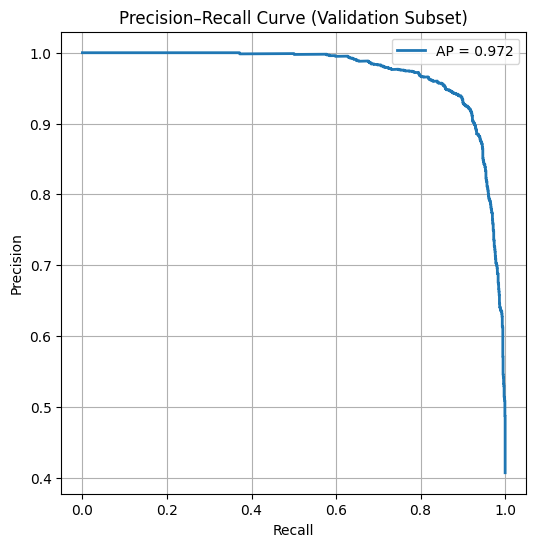

In [26]:
try:
    # Precision–Recall Curve
    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
    avg_prec = average_precision_score(y_true, y_prob)

    plt.figure(figsize=(6, 6))
    plt.plot(recall, precision, label=f'AP = {avg_prec:.3f}', linewidth=2)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision–Recall Curve (Validation Subset)")
    plt.legend()
    plt.grid(True)
    plt.show()

except Exception as e:
    print("Could not compute PRC:", e)


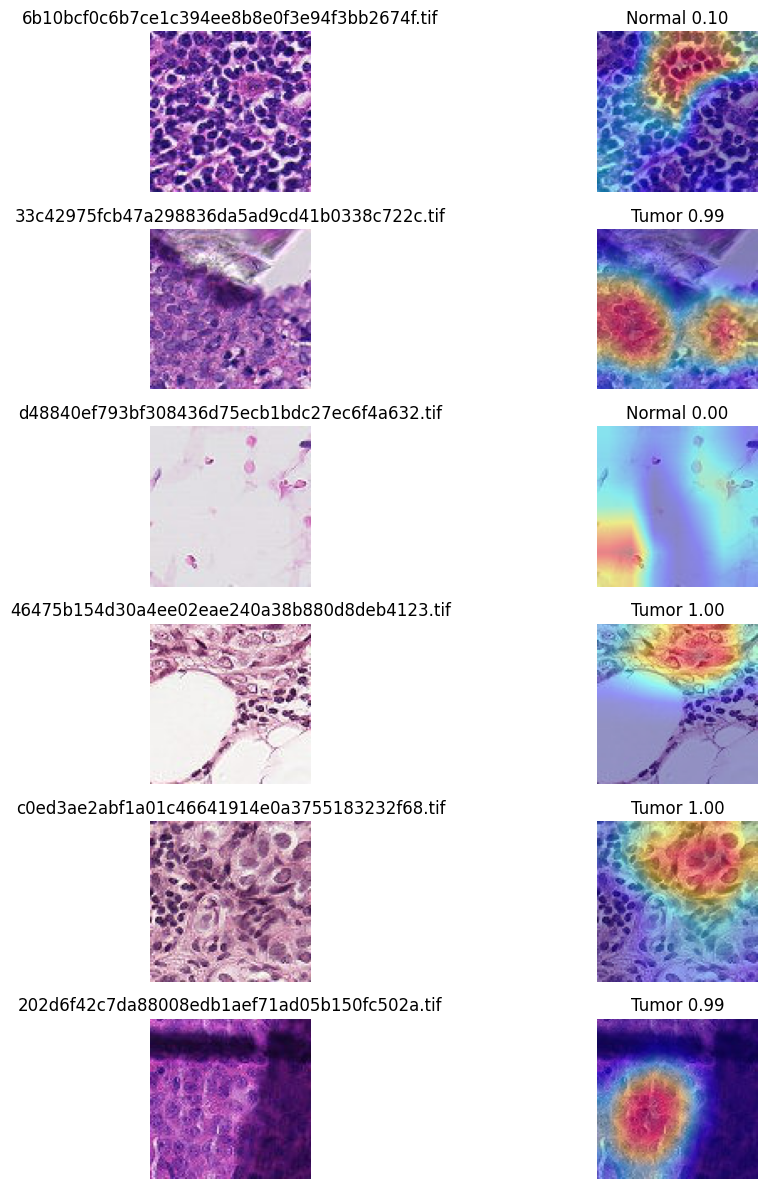

All done. Download outputs from Kaggle Output panel (patho_outputs).


In [27]:
# Visualization
def show_sample_overlays(n=8):
    rows = min(n, len(report_rows))
    plt.figure(figsize=(12, rows*2))
    for i in range(rows):
        r = report_rows[i]
        img_path = os.path.join(TRAIN_DIR, r["image_id"])
        orig = np.array(Image.open(img_path).convert("RGB"))
        heat = Image.open(os.path.join(HEATMAP_DIR, r["heatmap_file"]))
        heat = np.array(heat)
        plt.subplot(rows, 2, 2*i+1)
        plt.imshow(orig); plt.axis("off"); plt.title(r["image_id"])
        plt.subplot(rows, 2, 2*i+2)
        plt.imshow(heat); plt.axis("off"); plt.title(f"{r['pred_label']} {r['prob_tumor']:.2f}")
    plt.tight_layout()
    plt.show()

show_sample_overlays(6)
print("All done. Download outputs from Kaggle Output panel (patho_outputs).")